#### Pakkar

In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction import stop_words
import string
from keras.preprocessing import text, sequence
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Activation, Dropout, Flatten, Input, Embedding
from tensorflow.python.keras.optimizers import Adadelta
from tensorflow.python.keras.layers import Conv1D, MaxPooling1D, GRU
import tensorflow as tf

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [3]:
tf.compat.v1.disable_eager_execution()

In [4]:
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt

#### Innlestur gagna

In [6]:
train_data = pd.read_csv('data/train.csv',delimiter=',')

test_data = pd.read_csv('data/test.csv',delimiter=',')


### Gagnasettið
Hér má sjá gagnasettið sem við þjálfum módelið á. Við erum með comment_text og hann er búið að greina (0 eða 1) hvort hann sé toxic, severe_toxic, obscene, threat, insult eða identity_hate.

In [7]:
display(train_data.head())
cols = train_data.columns
print('Dálkarnir eru: ')
for col in cols:
    print('- \t',col)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Dálkarnir eru: 
- 	 id
- 	 comment_text
- 	 toxic
- 	 severe_toxic
- 	 obscene
- 	 threat
- 	 insult
- 	 identity_hate


In [8]:
display(test_data.head())

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


### Text preprocessing


In [9]:

def textpreprocess(sentence):
    sentence = sentence.lower()
    
    #Taka út ensk stopporð
    stopwords = stop_words.ENGLISH_STOP_WORDS
    for sw in stopwords:
        if len(sw) > 1 and sw in sentence:
            sentence.replace(sw,'')
    
    #Taka út tölur
    sentence = ''.join([i for i in sentence if not i.isdigit()])
    
    #Taka út punkta, kommur og þannig lagað
    sentence=sentence.translate(str.maketrans('', '', string.punctuation))
    
    return sentence

In [10]:
drasl = train_data.to_numpy()

In [11]:
from matplotlib.colors import Normalize

Hér er þá búið að preprocessa textann

In [63]:
def getProcessedText(dataset):
    x_train = dataset.to_numpy()
    for i in range(len(x_train)):
        x_train[i] = textpreprocess(x_train[i])
    return x_train

In [13]:
x_train = train_data['comment_text'].to_numpy()
for i in range(len(x_train)):
    x_train[i] = textpreprocess(x_train[i])

In [14]:
temp= x_train

In [15]:
max_comment_length = len(train_data['comment_text'][0])

for comment in train_data['comment_text']:
    if len(comment) > max_comment_length:
        max_comment_length = len(comment)

In [16]:
def getSubet(dataset, size):
    return dataset[0:size]

Prófa að exclude-a bara toxic dálkinn og gera model á honum

In [17]:
toxicCol = train_data['toxic']
classes = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

In [18]:
# X_train = train_data['comment_text'].to_numpy()
X_train = temp
# y_train = (train_data.values[:,2:])
y_train = train_data[classes]
print(len(y_train), len(X_train))
# Set aside validation data for monitoring training progress

assert len(X_train) == len(y_train)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

print('=================')
print('|','train_data shape:', X_train.shape)
print('|',X_train.shape[0], 'train samples')
print('|',y_test.shape[0], 'test samples')
print('=================')

159571 159571
| train_data shape: (127656,)
| 127656 train samples
| 31915 test samples


### Hér er gagnasettinu skipt jafn á milli toxic og non toxic commenta
    #### skoða þetta from sklearn.metrics import classification_report
    
Bý hérna til þjálfunargögn með upprunalegum commentum þ.e. ekki upsampled

In [156]:
comments = train_data['comment_text']
original_testData = train_data

In [157]:
original_testData=original_testData.sample(frac=1)

original_X_testData=original_testData['comment_text']
original_Y_testData=original_testData[classes]

In [160]:
original_X_testData = getProcessedText(original_X_testData)
original_Y_testData=original_Y_testData.to_numpy()

In [161]:
df_majority = train_data[train_data.toxic==0]
df_minority = train_data[train_data.toxic==1]

In [162]:
df_majority=df_majority.sample(frac=1)
df_upsampled = pd.concat([pd.DataFrame(df_majority.values[0:len(df_minority)],columns=train_data.columns)
, df_minority])

In [163]:
df_upsampled=df_upsampled.sample(frac=1)
display(df_upsampled.head())

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
31615,53f6348bd9e5ef6e,piss off homo \n\nstop i say stop it,1,0,0,0,0,0
640,85a711bf9905af42,nicholas i think you are assuming abortion imp...,0,0,0,0,0,0
104395,2e8d843809f2603b,without consensus who the fuck do you think yo...,1,0,1,0,1,0
148725,512eaff7387d2f23,republic of mosquito \n\nfaggot faggot get off...,1,0,1,0,1,1
4112,dfa110aa2e4b33d5,can anyone find a blue paul terrier picture we...,0,0,0,0,0,0


In [164]:
upsampled_y_train = df_upsampled[classes]
upsampled_x_train = df_upsampled['comment_text']

In [165]:
upsampled_x_train = getProcessedText(upsampled_x_train)

In [166]:
assert len(upsampled_x_train) == len(upsampled_y_train)
X_train, X_test, y_train, y_test = train_test_split(upsampled_x_train, upsampled_y_train, test_size=0.2)

print('Hérna er þetta', len(X_test))
print('Hérna er þetta', len(y_test))

X_test=original_X_testData[0:len(X_test)]
y_test=original_Y_testData[0:len(y_test)]

print('=================')
print('|','train_data shape:', X_train.shape)
print('|',X_train.shape[0], 'train samples')
print('|',y_test.shape[0], 'test samples')
print('=================')

Hérna er þetta 6118
Hérna er þetta 6118
| train_data shape: (24470,)
| 24470 train samples
| 6118 test samples


In [167]:
max_words = 20000 # <- spurning um hvað þetta eigi að vera
output_vector_len = int(df_upsampled.fillna('').astype(str).apply(lambda x:x.str.len()).mean()[1])
tokenizer = text.Tokenizer(num_words=max_comment_length)
num_classes = 6

tokenizer.fit_on_texts(list(X_train))
tokTrain = tokenizer.texts_to_sequences(X_train)
tokTest = tokenizer.texts_to_sequences(X_test)

x_train=sequence.pad_sequences(tokTrain, maxlen=max_comment_length)
x_test=sequence.pad_sequences(tokTest, maxlen=max_comment_length)


#### Góð útskýring á multilabel classifier
https://medium.com/@vijayabhaskar96/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24

### 92% acc. model

In [171]:
inp = Input(shape=(max_comment_length,))
model = Sequential()
model = Embedding(max_words, output_vector_len)(inp) 
#Embedded útskýring:
    #Turns positive integers (indexes) into dense vectors of fixed size.
######

#####
model = Dropout(0.5)(model)
model = Conv1D(filters=32, kernel_size=2, padding='same', activation='relu')(model)
model = MaxPooling1D(pool_size=2)(model)
model = Dropout(0.5)(model)
model = Conv1D(filters=32, kernel_size=2, padding='same', activation='relu')(model)
model = MaxPooling1D(pool_size=2)(model)
model = Dropout(0.5)(model)
model = GRU(128)(model)

model = Dense(64, activation="relu")(model)
model = Dense(32, activation="relu")(model)
model = Dense(16, activation="relu")(model)
model = Dense(6, activation="sigmoid")(model)
model = Model(inputs=inp, outputs=model)
model.compile(loss='binary_crossentropy', optimizer=Adadelta(), metrics=[tf.keras.metrics.AUC()])
# model.compile(loss='sparse_categorical_crossentropy', optimizer=Adadelta(), metrics=['accuracy'])
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 5000)]            0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 5000, 334)         6680000   
_________________________________________________________________
dropout_16 (Dropout)         (None, 5000, 334)         0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 5000, 32)          21408     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 2500, 32)          0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 2500, 32)          0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 2500, 32)          2080

In [169]:
#Sjá hvernig y- þjálfunargögnin líta út
print(y_train[0:4])

       toxic severe_toxic obscene threat insult identity_hate
102544     1            0       0      0      0             0
1104       0            0       0      0      0             0
82566      1            1       1      0      1             1
31         0            0       0      0      0             0


In [172]:
batch_size = 32
epochs = 1
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose = 1,
                    validation_split=0.1)
score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

print('Test acc: {}'.format(score[1]))

Train on 22023 samples, validate on 2447 samples
6118/6118 [==============================] - 82s 13ms/sample - loss: 0.1971 - auc: 0.9164
Test acc: 0.9164426922798157


In [75]:
print(x_test.shape)

(6118, 5000)


In [76]:
predictions = model.predict(x_test,batch_size=32, verbose=0)

In [77]:
print(predictions)

[[0.47008893 0.02315657 0.12893164 0.01507867 0.1503449  0.05878903]
 [0.59849006 0.06102102 0.24003151 0.04465153 0.26126352 0.10866596]
 [0.9412674  0.14670779 0.6007785  0.08213215 0.532858   0.15021421]
 ...
 [0.9835127  0.06364855 0.6647508  0.02560893 0.5215145  0.0654731 ]
 [0.9509771  0.02470218 0.3841281  0.00876251 0.33090505 0.03751686]
 [0.87502795 0.04224735 0.3462971  0.02132561 0.32201153 0.06567137]]


In [80]:
assert predictions.shape == y_test.shape
print(predictions.shape)
print(y_test.shape)

(6118, 6)
(6118, 6)


In [143]:
for line in range(predictions.shape[0]):
    for item in range(predictions.shape[1]):
        if predictions[line,item] > 0.5:
            predictions[line,item] = 1
        else:
            predictions[line,item] = 0
        

In [146]:
print(predictions.astype(int))
# x.astype(int)
# print(y_test)

[[0 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 1 0 1 0]
 ...
 [1 0 1 0 1 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]]


In [155]:

print(predictions.shape)

(6118, 6)


In [117]:
print(arr.shape)
fjoldi = (arr.shape[0]*arr.shape[1])
print(rett/fjoldi)
print(vitlaust/fjoldi)

(6118, 6)
0.9205350332352621
0.07946496676473794


In [173]:
def plot_acc_params(param, train_acc_, val_acc_, param_name, title):
    plt.plot(param, train_acc_,label='Training accuracy')
    plt.plot(param, val_acc_,label='Validation accuracy')
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def find_best_SVM_params(Cs, gammas, kernel_, xtrain, ytrain, xval, yval):
    training_acc = np.zeros(len(Cs))
    val_acc = np.zeros(len(Cs))
    # ignores the gamma values if linear
    if kernel_ != 'linear':
        training_acc = np.zeros((len(Cs), len(gammas)))
        val_acc = np.zeros((len(Cs), len(gammas)))
    
    for i in range(len(Cs)):
        print("c: ", Cs[i])
        if kernel_ != 'linear':
            for j in range(len(gammas)):
                print("gamma: ", gammas[j], end =" ")
                clf = OneVsRestClassifier(SVC(gamma=gammas[j], C = Cs[i], kernel = kernel_))
                clf.fit(xtrain, ytrain)
                val_acc[i, j] = get_row_accuracy(yval, clf.predict(xval))
                training_acc[i, j] = get_row_accuracy(ytrain, clf.predict(xtrain))
            print()
        else:
            clf = OneVsRestClassifier(SVC(C = Cs[i], kernel = kernel_))
            clf.fit(xtrain, ytrain)
            val_acc[i] = get_row_accuracy(yval, clf.predict(xval))
            training_acc[i] = get_row_accuracy(ytrain, clf.predict(xtrain))
#     print('Train acc \n', training_acc)
#     print('Validation acc \n', val_acc)
    return training_acc, val_acc

# Utility function to move the midpoint of a colormap to be around
# the values of interest.
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

def plot_heatmap(data_matrix, title, xlabel, ylabel, x_values, y_values, vmin_, midpoint_):
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(data_matrix, interpolation='nearest', cmap=plt.cm.seismic,
               norm=MidpointNormalize(vmin=vmin_, midpoint=midpoint_))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    
    plt.grid(None)
    plt.xticks(np.arange(len(x_values)), x_values, rotation=45)
    plt.yticks(np.arange(len(y_values)), y_values)
    plt.title(title)
    plt.show()

In [176]:
import seaborn as sn
def plot_conf_mat(mat, cmap_="OrRd" ):
    tn, fp, fn, tp  = mat.ravel()
    print('-'*50)
    print("TN: {}\t FP: {} \nFN: {}\t TP: {}".format(tn, fp, fn, tp))
    print("The sensitivity/recall is: {:.2%}".format(tp/(tp+fn)))
    print("The specificity is: {:.2%}".format(tn/(tn+fp)))
    print("The precision is: {:.2%}".format(tp/(tp+fp)))
    print('-'*50)
    ax = sn.heatmap(mat, annot=True, fmt="d", cmap=cmap_)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    # Lætur tölurnar vera í miðjum kassanum
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()

--------------------------------------------------
TN: 29086	 FP: 6302 
FN: 838	 TP: 482
The sensitivity/recall is: 36.52%
The specificity is: 82.19%
The precision is: 7.10%
--------------------------------------------------


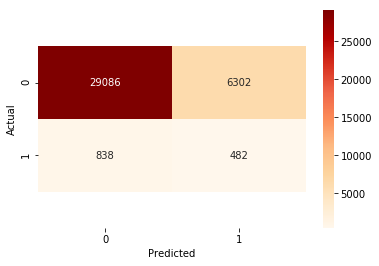

In [179]:
### from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

totals_mat = confusion_matrix(y_test.astype(int).ravel(), predictions.astype(int).ravel())
plot_conf_mat(totals_mat)

# conmat = multilabel_confusion_matrix(y_test.astype(int), predictions.astype(int))
# # print(conmat)
# for mat in conmat:
#     tn, fp, fn, tp  = mat.ravel()
#     print('-'*100)
#     print("TN: {}, FP: {}, FN: {}, TP: {}".format(tn, fp, fn, tp))
#     print("The sensitivity is: {:.3%}".format(tp/(tp+fn)))
#     print("The specificity is: {:.3%}".format(tn/(tn+fp)))
#     plot_heatmap(mat, 'Validation accuracy', 'Predicted', 'True Label', 
#               (tn, fp), (fn,tp), np.min(mat), np.max(mat)-0.01)


In [154]:
inp = Input(shape=(max_comment_length,))
model = Sequential()
model = Embedding(max_words, output_vector_len)(inp) 
#Embedded útskýring:
    #Turns positive integers (indexes) into dense vectors of fixed size.
######

#####
model = Conv1D(filters=32, kernel_size=2, padding='same', activation='relu')(model)
model = MaxPooling1D(pool_size=2)(model)
model = Dropout(0.5)(model)
model = Conv1D(filters=32, kernel_size=2, padding='same', activation='relu')(model)
model = MaxPooling1D(pool_size=2)(model)
model = Dropout(0.5)(model)
model = GRU(128)(model)
model = Dense(64, activation="relu")(model)
model = Dense(6, activation="sigmoid")(model)
model = Model(inputs=inp, outputs=model)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.compile(loss='sparse_categorical_crossentropy', optimizer=Adadelta(), metrics=['accuracy'])
model.summary()


batch_size = 128
epochs = 1
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose = 1,
                    validation_split=0.1)
score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

print('Test acc: {}'.format(score[1]))


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 5000)]            0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 5000, 330)         6600000   
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 5000, 32)          21152     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 2500, 32)          0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 2500, 32)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 2500, 32)          2080      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 1250, 32)          0   

In [43]:
import matplotlib.pyplot as plt
def teikna(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    plt.plot(acc)
    plt.plot(val_acc)
    plt.plot(val_loss)
    plt.plot(loss)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation','val. loss', 'loss'])
    mynd = plt.show()
    return mynd

## EHV drasl sem ég er ekki að nota atm

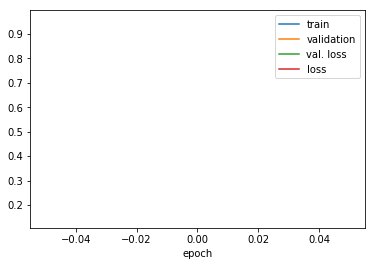

In [44]:
teikna(history)